# This project was used to perform Sentiment Analysis on customer feedback

Note that the project used data that is not available for public use so the results obtained if this is re-run with dummy data may be different. 

The following code is used for a point in time analysis. The real power of sentiment analysis is to track how it changes over time. Re-use this code for follow up assessments to see if the changes you made in your product/services had the desired impact.

## Load Packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers

     |████████████████████████████████| 2.0MB 16.1MB/s 
     |████████████████████████████████| 890kB 53.3MB/s 
     |████████████████████████████████| 3.2MB 38.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=43b2dfc8ba0428234262a29469c5218c80b351ccb8e79c7911409b3c03d3f376
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [3]:
import numpy as np 

import pandas as pd 

import string

import nltk 
nltk.download('stopwords')

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier

from transformers import pipeline

from sklearn.metrics import classification_report

from sklearn.metrics import matthews_corrcoef

from sklearn.metrics import confusion_matrix

import ipywidgets as widgets

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Import Data

In [4]:
#data_dir='C:/Users/stace/data_bootcamp/Final project/Models/BERT_binary_text_classification - actual/data.csv'
data_dir = '/content/drive/MyDrive/Colab Notebooks/data.csv'

df = pd.read_csv(data_dir, header=0)
df.columns = ['Brand','Text','Sentiment_True']
df = df[df.Brand !='A/B']

df.head()

,Brand,Text,Sentiment_True
0,A,One of the other reviewers has mentioned that ...,1
1,A,A wonderful little production. The filming te...,1
2,A,I thought this was a wonderful way to spend ti...,1
3,A,Basically there's a family where a little boy ...,0
4,A,"Petter Mattei's ""Love in the Time of Money"" is...",1


### Explore Data

In [5]:
df.groupby(['Sentiment_True','Brand']).count()

Text
Sentiment_True Brand      
0              A        75
               B        62
1              A        55
               B        63

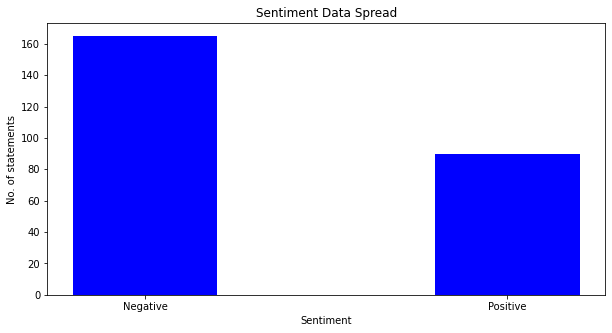

In [6]:
data = {'Negative':165, 'Positive':90}
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
plt.bar(courses, values, color ='blue',
        width = 0.4)
 
plt.xlabel("Sentiment")
plt.ylabel("No. of statements")
plt.title("Sentiment Data Spread")
plt.show()

## Set Up Data

In [7]:
features = df.Text
labels = df.Sentiment_True
features = np.asarray(features)
labels = np.asarray(labels)

## Process the Data

In [8]:
processed_features = []

for sentence in range(0, len(features)):
    #print(sentence)
    # Remove all the special characters
    # remove all single characters
    # Substituting multiple spaces with single space
    # Converting to Lowercase
    features[sentence] = "".join([char for char in features[sentence] if char not in string.punctuation])
    features[sentence] = ' '.join([w for w in features[sentence].split() if len(w)>1])
    features[sentence] = ' '.join(features[sentence].split())
    features[sentence] = features[sentence].lower()
    processed_features.append(features[sentence])

In [9]:
stopwords = nltk.corpus.stopwords.words('english')

In [10]:
vectorizer = TfidfVectorizer(stop_words=stopwords)

In [11]:
X = vectorizer.fit_transform(processed_features)
X = X.toarray()

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.30, random_state=42)

# Models

## Random Forest Classifer

In [13]:
# Run a quick RF model to have something to compare DistilBERT against

nb = RandomForestClassifier()
nb.fit(X_train,y_train)
y_pred = nb.predict(X_test)
y_pred_proba = nb.predict_proba(X_test)

In [14]:
df1 = pd.DataFrame()
df1['True_Sentiment'] = y_test
df1['Predicted_Sentiment'] = y_pred
df1['Predicted_Sentiment_Probability_0'] = y_pred_proba[:,0]
df1['Predicted_Sentiment_Probability_1'] = y_pred_proba[:,1]

df1.head()

,True_Sentiment,Predicted_Sentiment,Predicted_Sentiment_Probability_0,Predicted_Sentiment_Probability_1
0,0,0,0.54,0.46
1,0,0,0.55,0.45
2,1,0,0.64,0.36
3,1,0,0.74,0.26
4,1,1,0.39,0.61


### Evaluate

In [15]:
# Classification Report

target_names = ['Negative', 'Positive']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    Negative       0.61      0.87      0.72        47
    Positive       0.45      0.16      0.24        31

    accuracy                           0.59        78
   macro avg       0.53      0.52      0.48        78
weighted avg       0.55      0.59      0.53        78



In [16]:
# Matthews correlation coefficient

matthews_corrcoef(y_test, y_pred)

0.0472859980755036

Text(69.0, 0.5, 'True Values')

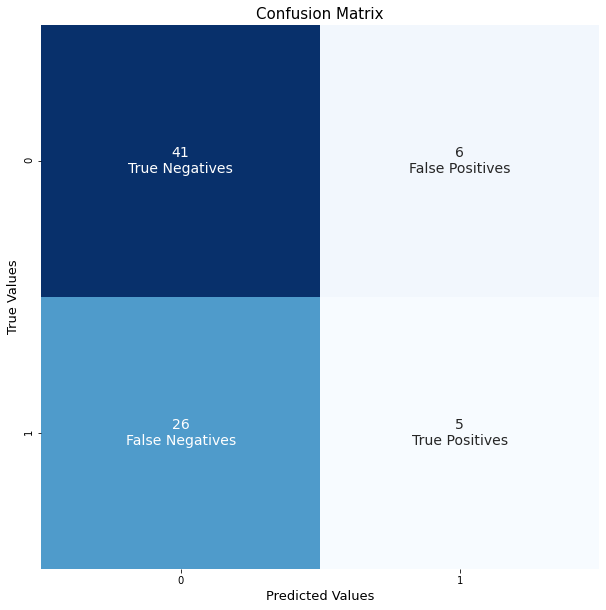

In [17]:
# Confustion Matrix 

cm = confusion_matrix(y_test,nb.predict(X_test))
plt.figure(figsize=[10,10])
ax = sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, annot_kws={"size": 14}, fmt='g')
cmlabels = ['True Negatives', 'False Positives','False Negatives', 'True Positives']
for i,t in enumerate(ax.texts):
    t.set_text(t.get_text() + "\n" + cmlabels[i])
plt.title('Confusion Matrix', size=15)
plt.xlabel('Predicted Values', size=13)
plt.ylabel('True Values', size=13)

## DistilBERT

This model makes use of a [Hugging Face pipeline](https://huggingface.co/transformers/main_classes/pipelines.html#transformers.TextClassificationPipeline) and is extremely simply to use. This is why it was chosen as the 'Best' Model because not only does it give the desired results with respect to Negative Recall, but it can be simply implemented into the business workflow going forward. There is room for improvement in overall model performance given additional project time. 

In [18]:
classifier = pipeline('sentiment-analysis')

In [19]:
df['Result'] = df['Text'].apply(lambda text: classifier(text))

In [20]:
df=df.explode('Result')
df['Sentiment']  = df['Result'].apply(lambda score_dict: score_dict['label'])
df['Score'] = df['Result'].apply(lambda score_dict: score_dict['score'])
df['Sentiment_Num'] = df['Sentiment'].apply(lambda c: 1 if c =='POSITIVE' else 0)

df.head()

,Brand,Text,Sentiment_True,Result,Sentiment,Score,Sentiment_Num
0,A,one of the other reviewers has mentioned that ...,1,"{'label': 'POSITIVE', 'score': 0.9942501187324...",POSITIVE,0.994250,1
1,A,wonderful little production the filming techni...,1,"{'label': 'POSITIVE', 'score': 0.9991052150726...",POSITIVE,0.999105,1
2,A,thought this was wonderful way to spend time o...,1,"{'label': 'POSITIVE', 'score': 0.8816632032394...",POSITIVE,0.881663,1
3,A,basically theres family where little boy jake ...,0,"{'label': 'NEGATIVE', 'score': 0.996266782283783}",NEGATIVE,0.996267,0
4,A,petter matteis love in the time of money is vi...,1,"{'label': 'POSITIVE', 'score': 0.9998071789741...",POSITIVE,0.999807,1


In [21]:
y_true = df.Sentiment_True
y_pred = df.Sentiment_Num

### Evaluate

In [22]:
# Classification Report

target_names = ['Negative', 'Positive']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    Negative       0.75      0.78      0.77       139
    Positive       0.73      0.69      0.71       118

    accuracy                           0.74       257
   macro avg       0.74      0.74      0.74       257
weighted avg       0.74      0.74      0.74       257



In [23]:
# Matthews correlation coefficient

matthews_corrcoef(y_true, y_pred)

0.48147152599431037

Text(69.0, 0.5, 'True Values')

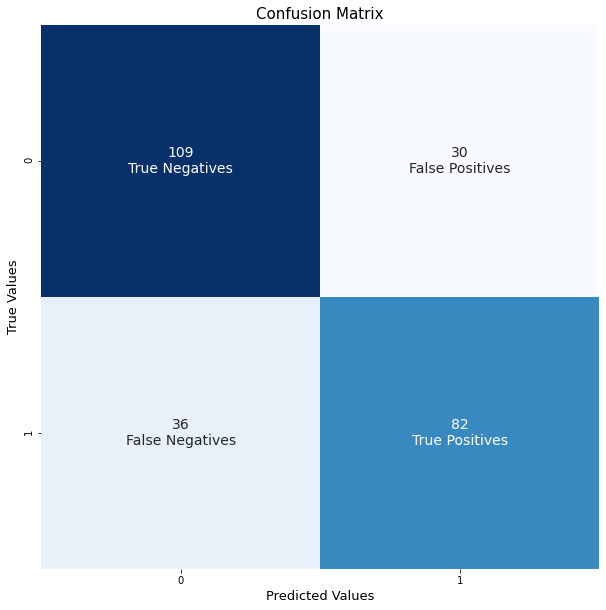

In [24]:
# Confustion Matrix 

cm = confusion_matrix(y_true,y_pred)
plt.figure(figsize=[10,10])
ax = sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, annot_kws={"size": 14}, fmt='g')
cmlabels = ['True Negatives', 'False Positives','False Negatives', 'True Positives']
for i,t in enumerate(ax.texts):
    t.set_text(t.get_text() + "\n" + cmlabels[i])
plt.title('Confusion Matrix', size=15)
plt.xlabel('Predicted Values', size=13)
plt.ylabel('True Values', size=13)

# Sentiment Score

In [25]:
df_all = df.copy()
df_all = df_all.reset_index()
dfA = df[df['Brand'] == 'A']
dfA = dfA.reset_index()
dfB = df[df['Brand'] == 'B']
dfB = dfB.reset_index()

In [26]:
positive = 0
negative = 0

for i in range(len(df_all.Sentiment_Num)):
    if df_all.Sentiment_Num[i] == 1:
      positive +=1
    else:
      negative += 1

positiveA = 0
negativeA = 0

for i in range(len(dfA.Sentiment_Num)):
    if dfA.Sentiment_Num[i] == 1:
      positiveA +=1
    else:
      negativeA += 1

positiveB = 0
negativeB = 0

for i in range(len(dfB.Sentiment_Num)):
    if dfB.Sentiment_Num[i] == 1: #positive
        positiveB +=1
    else:
        negativeB += 1

In [27]:
#Relative Proportional Difference.
#Sentiment = (P − N) / (P + N)
total_all = positive + negative
normalized_sentiment_all = (positive-negative)/total_all*100
totalA = positiveA + negativeA
normalized_sentimentA = (positiveA-negativeA)/totalA*100
totalB = positiveB + negativeB
normalized_sentimentB = (positiveB-negativeB)/totalB*100

print('For all the feedback there was a total of {} positive feedback statements and {} negative feedback statements'.format(positive,negative))
print('The overall dataset had a normalized sentiment score of {}'.format(normalized_sentiment_all))
print('For Brand A there was a total of {} positive feedback statements and {} negative feedback statements'.format(positiveA,negativeA))
print('For Brand A there was a normalized sentiment score of {}'.format(normalized_sentimentA))
print('For Brand B there was a total of {} positive feedback statements and {} negative feedback statements'.format(positiveB,negativeB))
print('For Brand B there was a normalized sentiment score of {}'.format(normalized_sentimentB))

For all the feedback there was a total of 112 positive feedback statements and 145 negative feedback statements
The overall dataset had a normalized sentiment score of -12.840466926070038
For Brand A there was a total of 56 positive feedback statements and 74 negative feedback statements
For Brand A there was a normalized sentiment score of -13.846153846153847
For Brand B there was a total of 55 positive feedback statements and 70 negative feedback statements
For Brand B there was a normalized sentiment score of -12.0


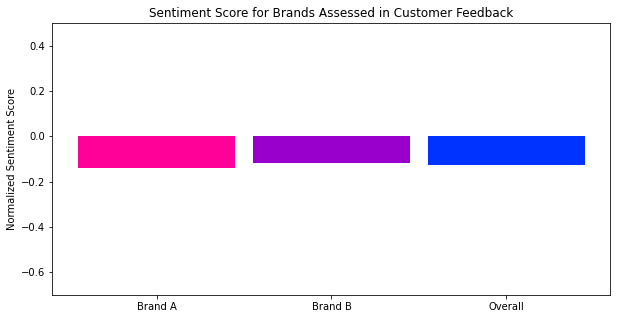

In [28]:
# creating the dataset
data = {'Brand A':normalized_sentimentA/100, 'Brand B':normalized_sentimentB/100, 'Overall':normalized_sentiment_all/100}

#keys = brand
#values = sentiment score
brands = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
labels = ['Brand A', 'Brand B', 'Overall']
# creating the bar plot
plt.bar(brands, values, color =['#ff0099','#9900cc','#0033ff'], width = 0.9)
#plt.xlabel("Brand")
plt.ylabel("Normalized Sentiment Score")
plt.title("Sentiment Score for Brands Assessed in Customer Feedback")
plt.ylim(-0.7,0.5)
plt.show()

How does your data look? ^^ Is this the sentiment you expected to see for your Brand? Next step, how can we make the sentiment better? 

# Log of Models

Specific to this project

In [29]:
# Taken from my log book and captured here for context

results = {
    "Model": ['VADER_0','TF-IDF NB_0','TF-IDF SVC_0', 'TF-IDF RF_0','TF-IDF RF_1','bert_base_cased_0','bert_base_cased_1','bert_base_cased_2','DistilBERT_0','DistilBERT_1'] ,
    "mcc": [0.259876874, 0.305031118, 0.258752251, 0.346311724, 0, 0.354581256, 0.103653498, -0.130930734, 0.74691358, 0.770428016] ,
    "accuracy": [0.552469136, 0.663265306, 0.67, 0.765306122, 0.75, 0,0,0, 0.431279028, 0.481519565] ,
    "neg_recall": [0.32994924, 0.66, 0.74, 0.93, 1.0,0,0,0, 0.75, 0.87] ,
    "pos_recall": [0.8976378, 0.67, 0.53, 0.37, 0.5,0,0,0, 0.74, 0.58] ,
    "neg_precision": [0.83333333, 0.82, 0.78, 0.77, 0.67, 0,0,0, 0.87, 0.79] ,
    "pos_precision": [0.46341463, 0.47, 0.47, 0.69, 1.0, 0,0,0, 0.55, 0.72] ,
    "neg_f1": [0.47, 0.73, 0.76, 0.84, 0.8, 0,0,0, 0.81, 0.83] ,
    "pos_f1": [0.61, 0.55, 0.5, 0.48, 0.67,0,0,0, 0.63, 0.64]
}
df = pd.DataFrame(results)
df

,Model,mcc,accuracy,neg_recall,pos_recall,neg_precision,pos_precision,neg_f1,pos_f1
0,VADER_0,0.259877,0.552469,0.329949,0.897638,0.833333,0.463415,0.47,0.61
1,TF-IDF NB_0,0.305031,0.663265,0.660000,0.670000,0.820000,0.470000,0.73,0.55
2,TF-IDF SVC_0,0.258752,0.670000,0.740000,0.530000,0.780000,0.470000,0.76,0.50
3,TF-IDF RF_0,0.346312,0.765306,0.930000,0.370000,0.770000,0.690000,0.84,0.48
4,TF-IDF RF_1,0.000000,0.750000,1.000000,0.500000,0.670000,1.000000,0.80,0.67
5,bert_base_cased_0,0.354581,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00
6,bert_base_cased_1,0.103653,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00
7,bert_base_cased_2,-0.130931,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00
8,DistilBERT_0,0.746914,0.431279,0.750000,0.740000,0.870000,0.550000,0.81,0.63
9,DistilBERT_1,0.770428,0.481520,0.870000,0.580000,0.790000,0.720000,0.83,0.64


/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


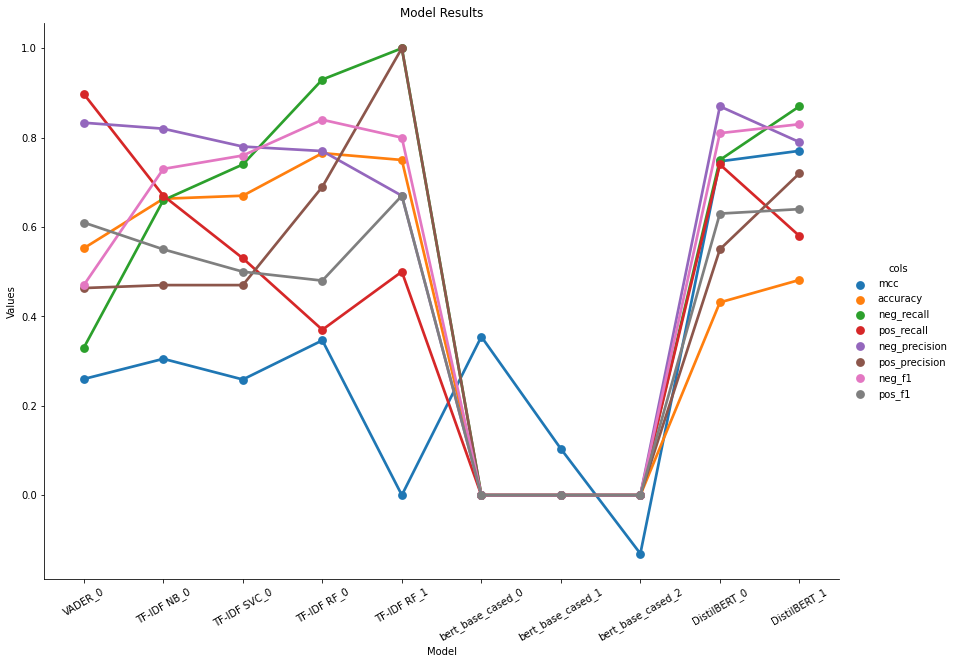

In [30]:
df1 = df.melt('Model', var_name='cols',  value_name='Values')
g = sns.factorplot(x="Model", y="Values", hue='cols', data=df1,height=8.27, aspect=11.7/8.27)
g.set(title='Model Results')
g.set_xticklabels(rotation=30)

In [31]:
# Top models with notes included

results_notes = {
    "Model": ['VADER_0','TF-IDF NB_0','TF-IDF SVC_0', 'TF-IDF RF_0','TF-IDF RF_1','DistilBERT_0','DistilBERT_1'] ,
    "mcc": [0.259876874, 0.305031118, 0.258752251, 0.346311724,  0.346311724, 0.74691358, 0.770428016] ,
    #"accuracy": [0.552469136, 0.663265306, 0.67, 0.765306122, 0.75,  0.431279028, 0.481519565] ,
    "neg_recall": [0.32994924, 0.66, 0.74, 0.93, 1.0, 0.75, 0.87] ,
    "neg_f1": [0.47, 0.73, 0.76, 0.84, 0.8, 0.81, 0.83] ,
    #"pos_f1": [0.61, 0.55, 0.5, 0.48, 0.67, 0.63, 0.64],
    "notes": ['Base NLP',
              'Super fast to execute - good first option for gut check',
              'Had the code ready to execute so was worth a quick try',
              'Super fast to execute - good inital results',
              'Very small dataset (recall = 1.0 not a good metric) - used Train Val Test; worth using GridSearch again only on Train Test',
              'State-of-the-Art Learning Transfer; very simple and good results',
              'Updated dataset to remove unclear entries, even better results. Very promising']
}

In [32]:
pd.set_option('max_colwidth', None)
df4 = pd.DataFrame(results_notes)
df4

,Model,mcc,neg_recall,neg_f1,notes
0,VADER_0,0.259877,0.329949,0.47,Base NLP
1,TF-IDF NB_0,0.305031,0.660000,0.73,Super fast to execute - good first option for gut check
2,TF-IDF SVC_0,0.258752,0.740000,0.76,Had the code ready to execute so was worth a quick try
3,TF-IDF RF_0,0.346312,0.930000,0.84,Super fast to execute - good inital results
4,TF-IDF RF_1,0.346312,1.000000,0.80,Very small dataset (recall = 1.0 not a good metric) - used Train Val Test; worth using GridSearch again only on Train Test
5,DistilBERT_0,0.746914,0.750000,0.81,State-of-the-Art Learning Transfer; very simple and good results
6,DistilBERT_1,0.770428,0.870000,0.83,"Updated dataset to remove unclear entries, even better results. Very promising"


In [33]:
results2 = {
    "Model": ['VADER_0','TF-IDF NB_0','TF-IDF SVC_0', 'TF-IDF RF_0','TF-IDF RF_1','DistilBERT_0','DistilBERT_1'] ,
    "mcc": [0.259876874, 0.305031118, 0.258752251, 0.346311724,  0.346311724, 0.74691358, 0.770428016] ,
    #"accuracy": [0.552469136, 0.663265306, 0.67, 0.765306122, 0.75,  0.431279028, 0.481519565] ,
    "neg_recall": [0.32994924, 0.66, 0.74, 0.93, 1.0, 0.75, 0.87] ,
    "neg_f1": [0.47, 0.73, 0.76, 0.84, 0.8, 0.81, 0.83] ,
    #"pos_f1": [0.61, 0.55, 0.5, 0.48, 0.67, 0.63, 0.64]
}
df2 = pd.DataFrame(results2)

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


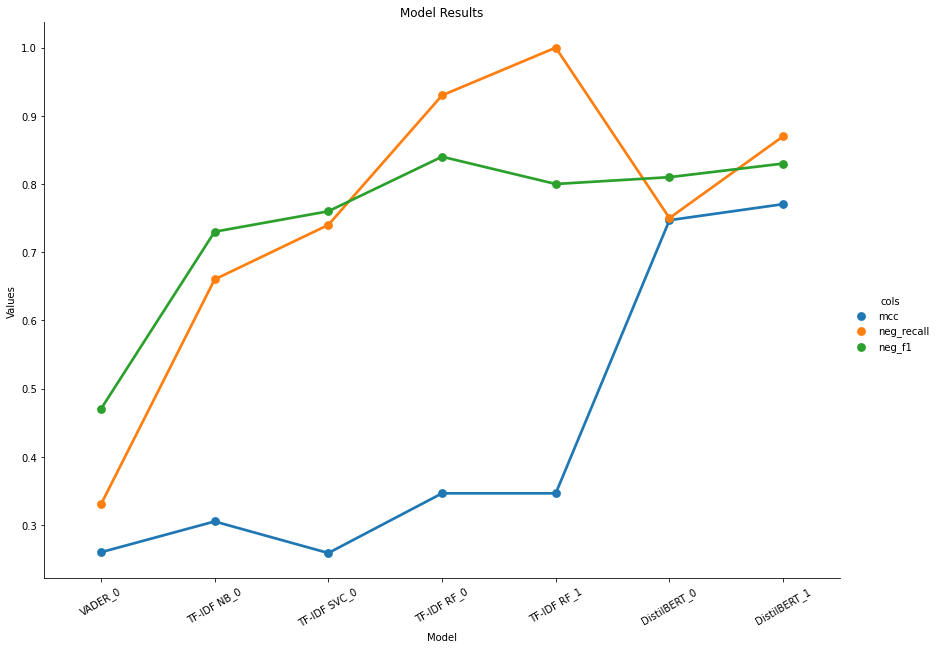

In [34]:
df3 = df2.melt('Model', var_name='cols',  value_name='Values')
g = sns.factorplot(x="Model", y="Values", hue='cols', data=df3,height=8.27, aspect=11.7/8.27)
g.set(title='Model Results')
g.set_xticklabels(rotation=30)

# Sentiment Widget

## Could be used for real-time analysis going forward

In [39]:
nlp_sentence_classif = pipeline('sentiment-analysis')

task = widgets.Dropdown(
    options=['sentiment-analysis'],
    value='sentiment-analysis',
    description='Task:',
    disabled=False
)

input = widgets.Text(
    value='',
    placeholder='Enter something',
    description='Your input:',
    disabled=False
)

def forward(_):
    if len(input.value) > 0: 
        if task.value == 'sentiment-analysis':
          output = nlp_sentence_classif(input.value)
        else:
          output = nlp_fill(input.value)                
        print(output)

input.on_submit(forward)
display(task, input)

Dropdown(description='Task:', options=('sentiment-analysis',), value='sentiment-analysis')

Text(value='', description='Your input:', placeholder='Enter something')

[{'label': 'POSITIVE', 'score': 0.9998799562454224}]
